### Libraries Requirement Check
This notebook was created using Kaggle Notebook & the following libraries at the time of creation.
* numpy 1.18.1
* pandas 1.0.3
* matplotlib.pylab 1.18.1
* sklearn 0.22.2.post1
* xgboost 1.0.2
* seaborn 0.10.0
* matplotlib.pylab 1.18.1
* re 2.2.1

The following files should exist at the  directory /kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/ (you should be able to access this by default)
1. agg_data.csv
2. rf_pred_30_10.model
3. rf_pred_30_10.csv
4. metamodel.model
5. xgb_pred_100_10.csv
6. xgb_pred_100_10.model

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook
from tqdm.notebook import tqdm
import re
import sklearn
from sklearn.preprocessing import LabelEncoder
from itertools import product
import time
import os
import gc
import pickle
import xgboost
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
pd.set_option('display.max_columns',100)
import os

for p in [np, pd, plt, sklearn, xgboost,sns,plt,re]:
    print (p.__name__, p.__version__)

numpy 1.18.1
pandas 1.0.3
matplotlib.pylab 1.18.1
sklearn 0.22.2.post1
xgboost 1.0.2
seaborn 0.10.0
matplotlib.pylab 1.18.1
re 2.2.1


# 1. tldr; Summary
The numbers of holidays for each month are added as I hypothesize they affect sales.
1. Thanks to [Schrodinger](https://www.kaggle.com/lonewolf45) for the excellent [notebook](https://www.kaggle.com/lonewolf45/coursera-final-project) that performs extraordinary ETL & XGB modelling. I learn a lot from this, parts of the source code there are reused and refactored to fit the author's coding style. 

2. The following are the original contributions by the author:
> * EDA
> * Augmenting Russia holiday information to the data
> * Augmenting popular titles/keywords to the item category such as 'Call of Duty', 'Star Wars'
> * Apply Mean encoding to vacation 'season' relative to the target
> * Ensemble using Linear Regression

# > Run the next cell to load preprocessed data, serialized models, and predict
Please expect to wait for 10 minutes for ETL, load model, and predict.
For recreating model from the scratch, please check this [notebook](https://www.kaggle.com/rrrrrikimaru/create-model-simple-e-to-e-eda-to-ensemble) 

In [2]:
import numpy as np 
import pandas as pd 
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from sklearn.preprocessing import LabelEncoder
from itertools import product
import time
import os
import gc
import pickle
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
pd.set_option('display.max_columns',100)
import os

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:#tqdm(df.columns):
        col_type = df[col].dtypes

        if col_type=='object':
            df[col] = df[col].astype('category')

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def display_status(message):
    from IPython.display import display, clear_output
    import time
    display(message) # print string
    clear_output(wait=True)
    

print('Available datasets:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

start = time.time()
display_status('Load aggregated data (1/3)')
agg_data = pd.read_csv('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/agg_data.csv')
agg_data = reduce_mem_usage(agg_data)


X_test = agg_data[agg_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_test.fillna(0,inplace=True)

del agg_data
gc.collect()

basepath= '../input/competitive-data-science-predict-future-sales/'
test = pd.read_csv( basepath+"test.csv" )

display_status('Load serialized models (2/3) --- Time elapsed:{0} secs'.format(time.time()-start))
rf = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/rf_pred_30_10.model', 'rb'))
xgb = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/xgb_pred_100_10.model', 'rb'))
meta_model = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/metamodel.model', 'rb'))

display_status('Final prediction (3/3) --- Time elapsed:{0} secs'.format(time.time()-start))
meta_test = pd.DataFrame({'ID':test.index,'pred_1':rf.predict(X_test),'pred_2':xgb.predict(X_test)})
X_meta_test = meta_test[['pred_1','pred_2']]

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": meta_model.predict(X_meta_test).clip(0, 20)
})
submission.to_csv('meta_model_pred.csv', index=False)
submission.to_csv('submission.csv', index=False)
print('Final prediction submission.csv file has been generated. Thanks for your patience')

del rf, xgb, meta_model, meta_test, X_meta_test, submission, X_test
gc.collect()

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  27 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.2s finished


Final prediction submission.csv file has been generated. Thanks for your patience


14

# 2. Exploratory Data Analysis

### Load Data

In [3]:
import numpy as np 
import pandas as pd 
import catboost
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from sklearn.preprocessing import LabelEncoder
from itertools import product
import time
import os
import gc
import pickle
from xgboost import XGBRegressor
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
pd.set_option('display.max_columns',100)
import os


basepath= '../input/competitive-data-science-predict-future-sales/'

items = pd.read_csv(basepath+"items.csv")
item_categories = pd.read_csv(basepath+"item_categories.csv")
shops = pd.read_csv(basepath+"shops.csv")
train = pd.read_csv( basepath+"sales_train.csv" )
#train = train.sample(20000) #for quick Proof of Concept, sample 20000
test = pd.read_csv( basepath+"test.csv" )
print('All data has been loaded.')

All data has been loaded.


The data mostly consists of PC, Entertainment, Game related. It can be suspected that the sales will be seasonal based on popularity and holidays. Here are my 3 hypotheses:
1. Holidays affect sales
2. Popular titles (ex.: games) are bestsellers & deserve their own categories
3. Data leaks are unlikely for test data for the following reasons: (a) there are some debut items 
, (b) the target variables to guess by LB probing are massive (between -1 to clipped 20)
, (c) shops may sell 'classical' items (items that has long been not sold, suddenly appears back in certain period of time)

### First suspect: holidays affect sales

206

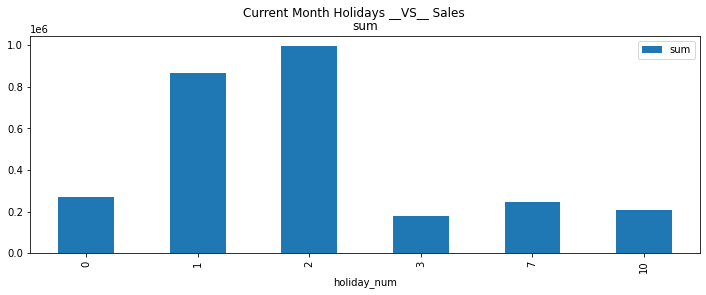

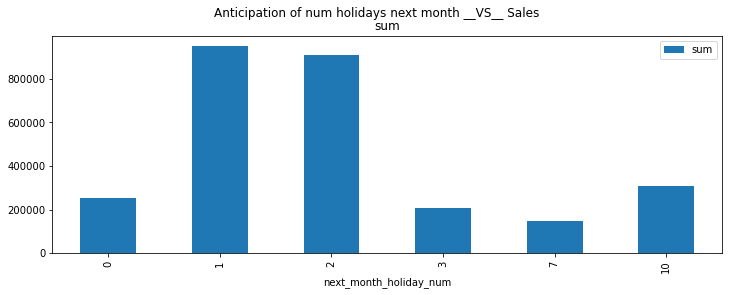

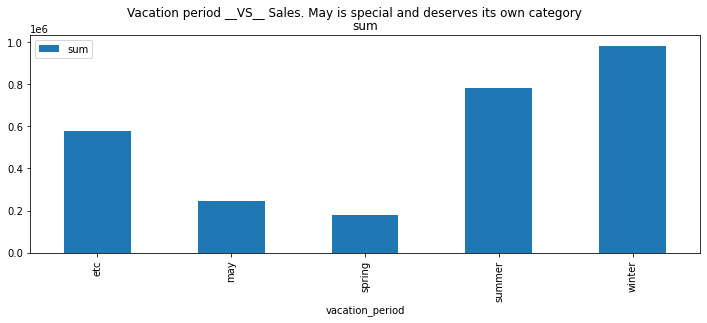

In [4]:
agg_data = pd.read_csv('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/agg_data.csv')
cols = ['holiday_num','item_cnt_month','next_month_holiday_num','vacation_period']

agg_data[cols].groupby(["holiday_num"], as_index=False 
                      ).agg({"item_cnt_month": ["sum"] }
                           ).plot(kind='bar',x='holiday_num',y='item_cnt_month',
                                  title='Current Month Holidays __VS__ Sales', subplots=True, rot=90)

agg_data[cols].groupby(["next_month_holiday_num"] , as_index=False 
                      ).agg({"item_cnt_month": ["sum"] }
                           ).plot(kind='bar',x='next_month_holiday_num',y='item_cnt_month',
                                  title='Anticipation of num holidays next month __VS__ Sales', subplots=True, rot=90)

# Remapped to string since the original agg_data was already mean-encoded
days = pd.Series(['winter','etc','spring','etc','may',  'summer','summer','summer','etc','winter','winter','winter'])
agg_data["vacation_period"] = agg_data["month"].map(days).astype('category')
agg_data[cols].groupby(["vacation_period"] , as_index=False 
                      ).agg({"item_cnt_month": ["sum"] }
                           ).plot(kind='bar',x='vacation_period',y='item_cnt_month',
                                  title='Vacation period __VS__ Sales. May is special and deserves its own category', subplots=True, rot=90)

del agg_data, days
gc.collect()

### Popular games are bestsellers

8299

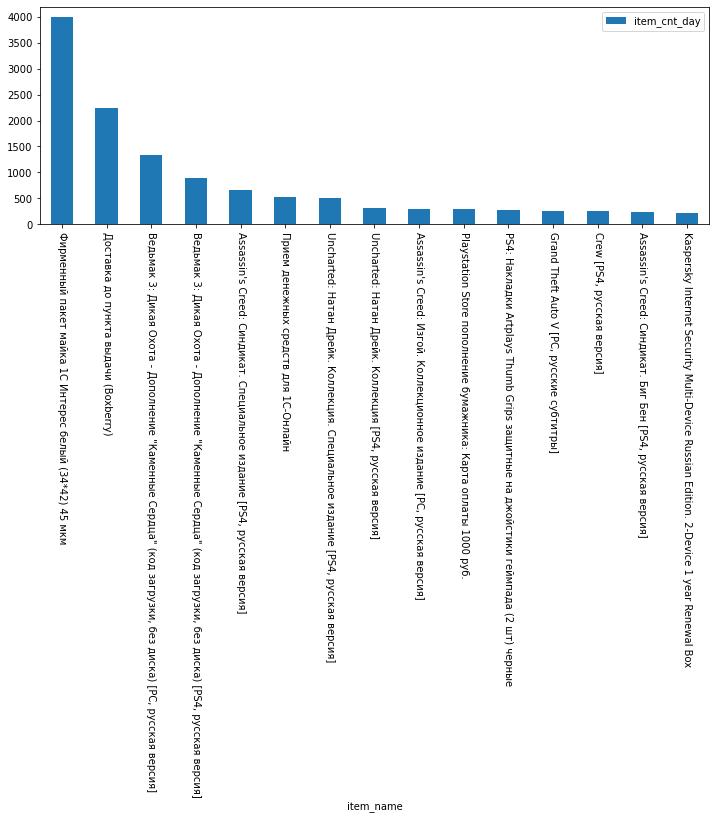

In [5]:
alldata = None
alldata = train.merge(items, how='inner', on='item_id' )
alldata= alldata.merge(item_categories, how='inner', on='item_category_id' )
alldata = alldata.merge(shops,how='inner', on='shop_id')
alldata['year'] = pd.to_datetime(alldata['date']).dt.year
alldata['month'] = pd.to_datetime(alldata['date']).dt.month
alldata['year_month'] = alldata['year'].astype(str) + '-' + alldata['month'].astype(str)
popular_game_oct2015 = alldata.groupby(['year_month','item_category_name','item_name'],as_index=False).sum()
cols=['date',	'date_block_num',	'item_name', 	'item_cnt_day', 'shop_id']

top_100 = popular_game_oct2015[popular_game_oct2015['year_month']=='2015-10'].sort_values(by=['item_cnt_day'], ascending=False).iloc[:100,:]
top_100[['item_name','item_cnt_day']].head(15).plot.bar(x='item_name', rot=-90)


#free memory
del alldata,popular_game_oct2015,top_100
gc.collect()

as shown above, given just a month away from Nov 2015(the period to predict), the top-15 sales have repeated popular game products such as Assassin's Creed, Uncharted, GTA V contributing to the sales. Capitalizing this on facts, some keywords from the item_name will be used as category.

## Thought on Data Leaks
Let us profile the numbers of unique data and plot pairs of (item_id, plot_id)

Train unique:
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64    

Test unique:
ID         214200
shop_id        42
item_id      5100
dtype: int64


4032

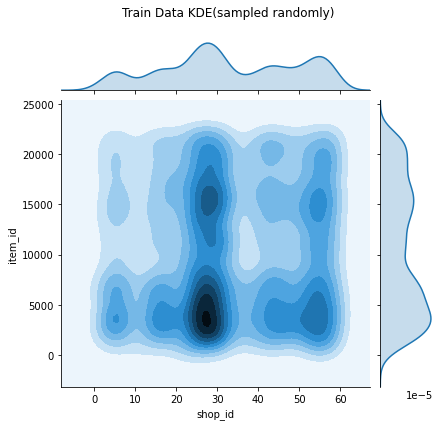

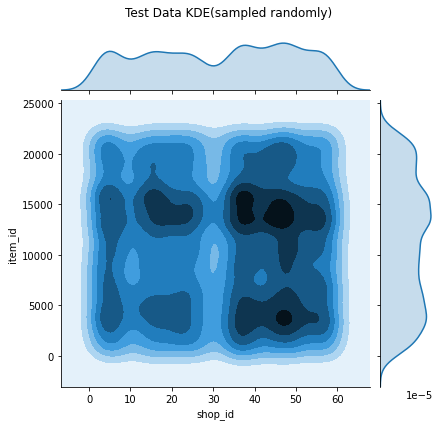

In [6]:
# Let sample some of the data and plot its kernel distribution between ('shop_id','item_id') pair
print('Train unique:\n{0}    \n\nTest unique:\n{1}'.format( train.nunique(), test.nunique()))
train_g = sns.jointplot(x="shop_id", y="item_id", data=train[['shop_id','item_id']].sample(10000), kind="kde")
plt.subplots_adjust(top=0.9)
train_g.fig.suptitle('Train Data KDE(sampled randomly)')
test_g = sns.jointplot(x="shop_id", y="item_id", data=test[['shop_id','item_id']].sample(10000), kind="kde")

plt.subplots_adjust(top=0.9)
test_g.fig.suptitle('Test Data KDE(sampled randomly)')

del test_g, train_g
gc.collect()

The distributions of item_id and shop_id vary and it is inconclusive that data leakage exists, however since target value is not binary value of 0/1, the possibility target values (from -1 to upper-clipped 20) to guess based on LB probing(submit & check score up/down) are massive. I decided to proceed to the ETL instead. In addition there are some debut items (item_id) in the test set as shown below:

In [7]:
num_debut = len(set(test['item_id']) - set(train['item_id']))
total_test = len(set(test['item_id']))
pctg = (num_debut/total_test)*100
print ('num of debut items: {0} ({1}%) out of {2} items'.format(num_debut,pctg,total_test))

num of debut items: 363 (7.11764705882353%) out of 5100 items


# 3. How the Data was Transformed and ETL-ed
* The data will be group and merged by these 5 columns and some of their combination: "date_block_num", "shop_id","item_id",'subtype_code','shop_city'. This is to extract their local, group, and global aggregated operation results.
* The data was also transformed using scikit transformer. This will save memory since the data will be mostly stored in int format (The author followed the way of the original source code mentioned above).

# 4. Hyperparameter Optimization
The optimum number of trees for Random Forest was approximated below

0

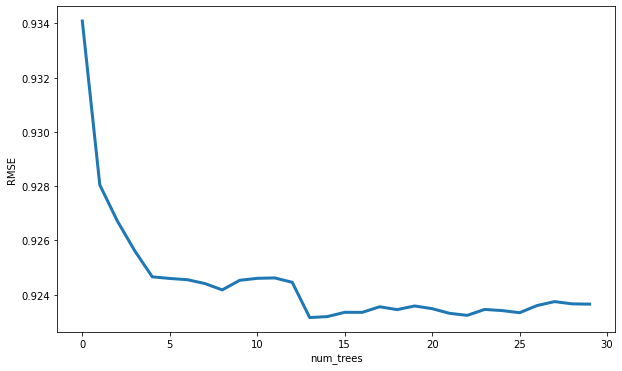

In [8]:
# Hyperparameter
gc.collect()
agg_data = pd.read_csv('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/agg_data.csv')

X_train = agg_data[agg_data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = agg_data[agg_data.date_block_num < 33]['item_cnt_month']
X_val = agg_data[agg_data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_val = agg_data[agg_data.date_block_num == 33]['item_cnt_month']
X_test = agg_data[agg_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

X_train.fillna(0,inplace=True)
X_val.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

rf_filename = 'rf_pred_30_10.model'
rf = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/'+rf_filename, 'rb'))

del agg_data
gc.collect()


predictions = []
for tree in rf.estimators_:
    predictions.append(tree.predict(X_val)[None, :])

from sklearn.metrics import mean_squared_error
predictions = np.vstack(predictions)
scores = []

acc = []
temp = [0] * len(predictions[0])
for i in range(len(predictions)):
    temp += predictions[i] 
    acc.append(temp/(i+1))

scores=[]
for pred in acc:
    scores.append(np.sqrt(mean_squared_error(y_val, pred)))

scores
plt.figure(figsize=(10, 6))
plt.plot(scores, linewidth=3)
plt.xlabel('num_trees')
plt.ylabel('RMSE')

del scores,predictions, rf
gc.collect()

In terms of RMSE, we can see above that the num_trees round 10 trees was quite optimum.

# 5. Feature Importances

2567

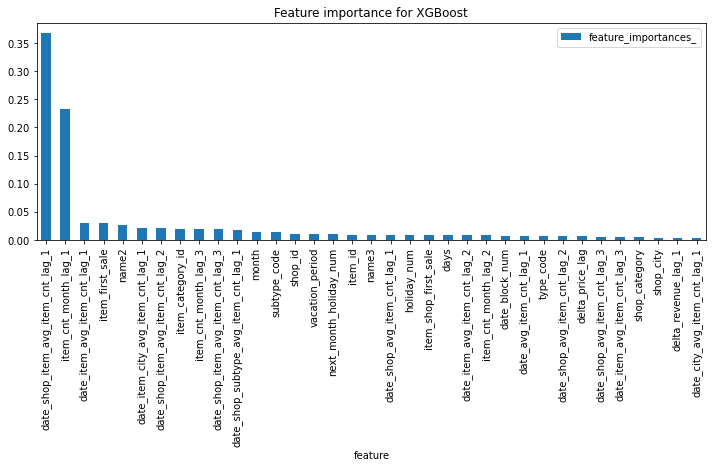

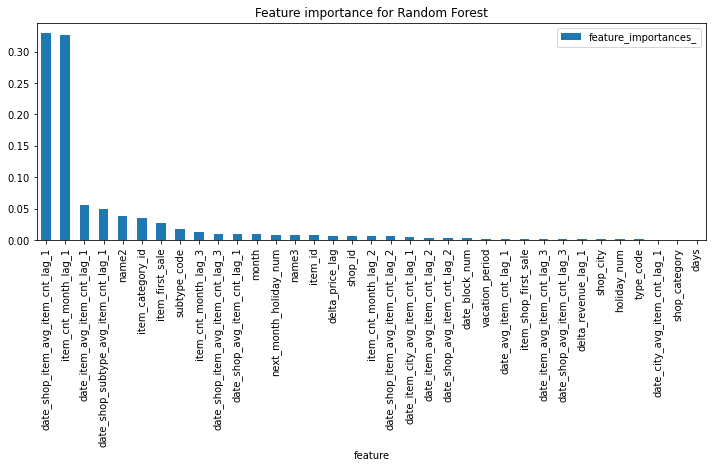

In [9]:
def plot_feature_imp(model,model_name):
    global X_train
    df = pd.DataFrame({'feature':X_train.columns,
                       'feature_importances_':model.feature_importances_}).sort_values(by='feature_importances_', ascending=False)
    df.plot(x='feature',kind='bar',title='Feature importance for '+model_name)


xgb = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/xgb_pred_100_10.model', 'rb'))
plot_feature_imp(xgb,'XGBoost')

rf = pickle.load(open('/kaggle/input/create-model-simple-e-to-e-eda-to-ensemble/rf_pred_30_10.model', 'rb'))
plot_feature_imp(rf,'Random Forest')

del xgb, rf
gc.collect()

Both plots above of shows different importances between XGB and RF. Although both are still Tree based methods, both are ensembled anyway using Linear Regression. (please refer to the[ source code](https://www.kaggle.com/rrrrrikimaru/create-model-simple-e-to-e-eda-to-ensemble) for the details).

# Recreate models and predict from Scratch
# > Please check this link >> [notebook](https://www.kaggle.com/rrrrrikimaru/create-model-simple-e-to-e-eda-to-ensemble)  <<

### Thank you for reading till the end.
Any feedback is very welcomed.